In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.holtwinters import ExponentialSmoothing
plt.style.use('seaborn')

## Описание задания

In [2]:
with open('../data/stats/moving_average/Описание.txt') as f:
    print(f.read())

Для выполнения практического задания необходимо:
1. Открыть папку, соотвествующую своей группе.
2. Открыть папку с вариантом, совпадающим с вашим номером в списке.

В папке два файла, которые содержат разные временные ряды. В первом файле находится ряд с синусоидальным трендом. Во втором - с линейным.
Необходимо выделить тренд используя 4 метода:
1. Простое скользящее среднее (SMA)
2. Взвешенное скользящее среднее (WMA) особо типа (как обсуждалось на лекции)
3. Экспоненциальное сглаживание (EMA)
4. Двойное экспоненциальное сглаживание (DEMA)

Каждые метод требует подбора некоторых параметров:
SMA и WMA - размер окна, EMA - параметр сглаживания A, DEMA - параметр сглаживания вокруг тренда A и параметр сглаживания самого тренда B.
Необходимо подобрать оптимальные значения соотвествующих параметров, используя Q-статистику Льюнг-Бокса при m = 5. Оптимальными параметрами будем считать те, что минимизируют приведенную статистику.
В качестве размеров окна перебрать значения: 3, 5, 7, 9; в кач

## Импорт данных

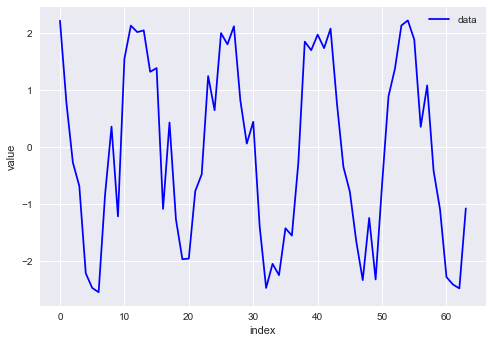

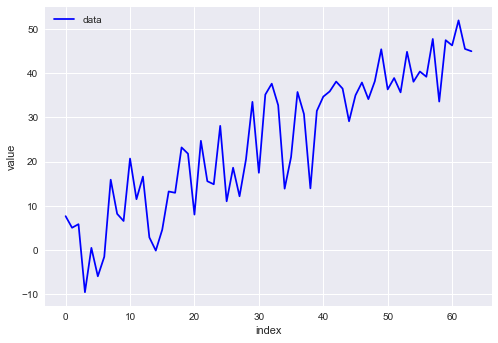

In [3]:
sin_trend_data = pd.read_csv('../data/stats/moving_average/1.txt', header=None, names=['data'])
lin_trend_data = pd.read_csv('../data/stats/moving_average/2.txt', header=None, names=['data'])

# Визуализация исходных данных
sin_trend_data.plot(color='blue', xlabel='index', ylabel='value')
lin_trend_data.plot(color='blue', xlabel='index', ylabel='value');

## 1. Простое скользящее среднее (SMA)

In [4]:
def simple_moving_average(data, window_sizes=[3, 5, 7, 9]):
    """ Выделение тренда с помощью простого скользящего среднего (SMA). """
    
    # Определяем тренд для окон разного размера, считаем статистику Льюнг-Бокса и сохраняем полученные результаты
    opt_parameters = []
    for window_size in window_sizes:
        trend = data.rolling(window_size, center=True).mean()
        residuals = (data - trend).dropna()
        lb_value, p_value = acorr_ljungbox(residuals, lags=[5], return_df=False)
        opt_parameters.append((lb_value[0], p_value[0], trend, residuals, window_size))
    
    # Определяем тренд с наименьшей статистикой Льюнг-Бокса
    q_stat, p_value, trend, residuals, window_size = min(opt_parameters, key=lambda x: x[0])
    q_h0 = 'принимается' if p_value > 0.05 else 'отвергается'
    
    # Тест Дарбина-Уотсона
    dw_stat = durbin_watson(residuals)[0]
    dw_h0 = 'принимается' if (4 - 1.62 > dw_stat > 1.62) else 'отвергается' if ((dw_stat > 4 - 1.55) or (dw_stat < 1.55)) else 'в ситуации неопределённости => отвергается'

    # Визуализация оптимального тренда
    plt.title(f'Simple Moving Average ({window_size=})\nQ-статистика Льюнг-Бокса = {q_stat.round(2)}, p_value = {p_value.round(2)} ($H_{0}$ {q_h0})\nСтатистика Дарбина-Уотсона = {dw_stat.round(2)} ($H_{0}$ {dw_h0})')
    plt.plot(data.index, data, color='blue', label='Исходные данные')
    plt.plot(trend.index, trend, color='red', label='Выделенный тренд')
    plt.xlabel('index')
    plt.ylabel('value')
    plt.legend()
    plt.show()

Выделение тренда для данных с синусоидальным трендом (вся рассчитанная информация приведена на графике):

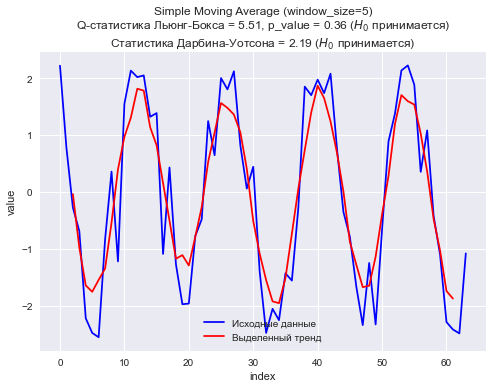

In [5]:
simple_moving_average(sin_trend_data)

Выделение тренда для данных с линейным трендом (вся рассчитанная информация приведена на графике):

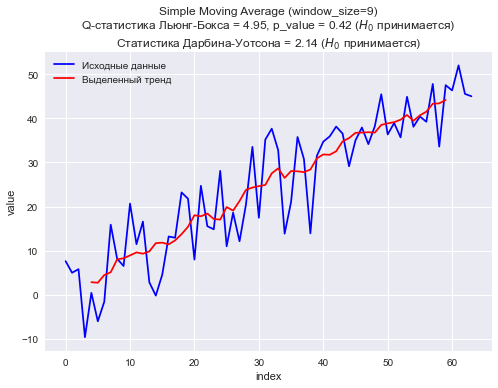

In [6]:
simple_moving_average(lin_trend_data)

## 2. Взвешенное скользящее среднее (WMA)

In [7]:
def weighted_moving_average(data, window_sizes=[3, 5, 7, 9]):
    """ Выделение тренда с помощью взвешенного скользящего среднего (WMA). """
    
    # Определяем тренд для окон разного размера, считаем статистику Льюнг-Бокса и сохраняем полученные результаты
    opt_parameters = []
    for window_size in window_sizes:
        
        # Строим полиномиальный тренд 2 порядка для каждого окна
        trend = np.array([])
        for i in range(0, len(data) - window_size):
            model = np.poly1d(np.polyfit(range(i, i + window_size), data.iloc[i:i + window_size].values.reshape(1, -1)[0], 1))
            trend = np.append(trend, model((i + i + window_size) / 2))
        
        # Считаем остатки (так как тренд построен для среднего из каждого окна, получилась такая неприятная формулка)
        residuals = np.array(data).reshape(1, -1)[0][window_size//2:-window_size//2] - trend
        lb_value, p_value = acorr_ljungbox(residuals, lags=[5], return_df=False)
        opt_parameters.append((lb_value[0], p_value[0], trend, residuals, window_size))
        
    # Определяем тренд с наименьшей статистикой Льюнг-Бокса
    q_stat, p_value, trend, residuals, window_size = min(opt_parameters, key=lambda x: x[0])
    q_h0 = 'принимается' if p_value > 0.05 else 'отвергается'
    
    # Тест Дарбина-Уотсона
    dw_stat = durbin_watson(residuals)    
    dw_h0 = 'принимается' if (4 - 1.62 > dw_stat > 1.62) else 'отвергается' if ((dw_stat > 4 - 1.55) or (dw_stat < 1.55)) else 'в ситуации неопределённости => отвергается'
    
    # Визуализация оптимального тренда
    plt.title(f'Weighted Moving Average ({window_size=})\nQ-статистика Льюнг-Бокса = {q_stat.round(2)}, p_value = {p_value.round(2)} ($H_{0}$ {q_h0})\nСтатистика Дарбина-Уотсона = {dw_stat.round(2)} ($H_{0}$ {dw_h0})')
    plt.plot(data.index, data, color='blue', label='Исходные данные')
    plt.plot(data.iloc[window_size//2:-window_size//2].index, trend, color='red', label='Выделенный тренд')
    plt.xlabel('index')
    plt.ylabel('value')
    plt.legend()
    plt.show()

Выделение тренда для данных с синусоидальным трендом (вся рассчитанная информация приведена на графике):

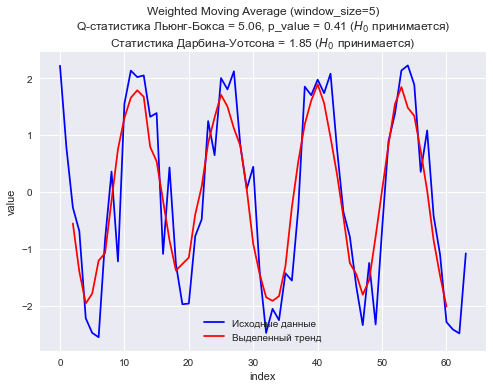

In [8]:
weighted_moving_average(sin_trend_data)

Выделение тренда для данных с линейным трендом (вся рассчитанная информация приведена на графике):

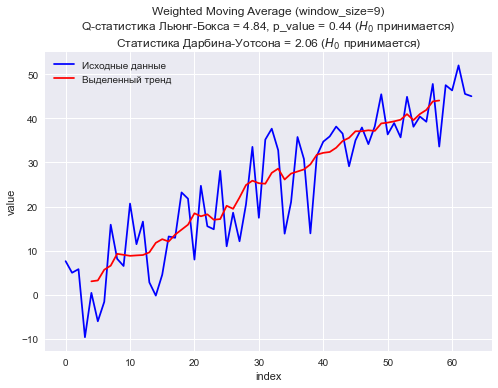

In [9]:
weighted_moving_average(lin_trend_data)

## 3. Экспоненциальное скользящее среднее (EMA)

In [10]:
def exponential_moving_average(data, smooth_factors=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    """ Выделение тренда с помощью экспоненциального скользящего среднего (EMA). """
    
    # Определяем тренд для разных параметров сглаживания, считаем статистику Льюнг-Бокса и сохраняем полученные результаты
    opt_parameters = []
    for smooth in smooth_factors:
        trend = data.ewm(alpha=smooth).mean()
        residuals = data - trend
        lb_value, p_value = acorr_ljungbox(residuals, lags=[5], return_df=False)
        opt_parameters.append((lb_value[0], p_value[0], trend, residuals, smooth))
    
    # Определяем тренд с наименьшей статистикой Льюнг-Бокса
    q_stat, p_value, trend, residuals, smooth_factor = min(opt_parameters, key=lambda x: x[0])
    q_h0 = 'принимается' if p_value > 0.05 else 'отвергается'
    
    # Тест Дарбина-Уотсона
    dw_stat = durbin_watson(residuals)[0]
    dw_h0 = 'принимается' if (4 - 1.62 > dw_stat > 1.62) else 'отвергается' if ((dw_stat > 4 - 1.55) or (dw_stat < 1.55)) else 'в ситуации неопределённости => отвергается'
    
    # Визуализация оптимального тренда
    plt.title(f'Exponential Moving Average ({smooth_factor=})\nQ-статистика Льюнг-Бокса = {q_stat.round(2)}, p_value = {p_value.round(2)} ($H_{0}$ {q_h0})\nСтатистика Дарбина-Уотсона = {dw_stat.round(2)} ($H_{0}$ {dw_h0})')
    plt.plot(data.index, data, color='blue', label='Исходные данные')
    plt.plot(trend.index, trend, color='red', label='Выделенный тренд')
    plt.xlabel('index')
    plt.ylabel('value')
    plt.legend()
    plt.show()

Выделение тренда для данных с синусоидальным трендом (вся рассчитанная информация приведена на графике):

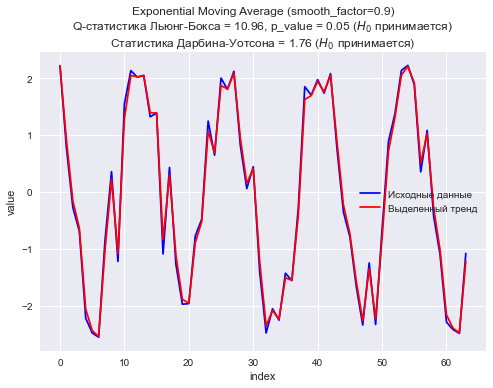

In [11]:
exponential_moving_average(sin_trend_data)

Выделение тренда для данных с линейным трендом (вся рассчитанная информация приведена на графике):

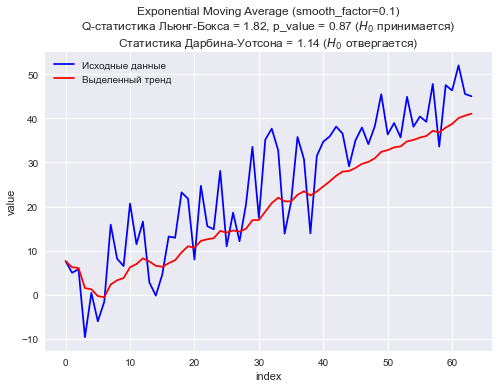

In [12]:
exponential_moving_average(lin_trend_data)

## 4. Двойное экспоненциальное скользящее среднее (DEMA)

In [13]:
def double_exponential_moving_average(data, smooth_factors=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    """ Выделение тренда с помощью двойного экспоненциального скользящего среднего (DEMA). """
    
    # Определяем тренд для разных параметров сглаживания (a и b), считаем статистику Льюнг-Бокса и сохраняем полученные результаты
    opt_parameters = []
    for smooth_a in smooth_factors:
        for smooth_b in smooth_factors:
            model = ExponentialSmoothing(data).fit(smoothing_level=smooth_a, smoothing_trend=smooth_b)
            trend = model.predict(start=1, end=len(data))
            residuals = np.array(data).reshape(1, -1)[0] - trend
            lb_value, p_value = acorr_ljungbox(residuals, lags=[5], return_df=False)
            opt_parameters.append((lb_value[0], p_value[0], trend, residuals, smooth_a, smooth_b))

    # Определяем тренд с наименьшей статистикой Льюнг-Бокса
    q_stat, p_value, trend, residuals, smooth_a, smooth_b = min(opt_parameters, key=lambda x: x[0])
    q_h0 = 'принимается' if p_value > 0.05 else 'отвергается'
    
    # Тест Дарбина-Уотсона
    dw_stat = durbin_watson(residuals)
    dw_h0 = 'принимается' if (4 - 1.62 > dw_stat > 1.62) else 'отвергается' if ((dw_stat > 4 - 1.55) or (dw_stat < 1.55)) else 'в ситуации неопределённости => отвергается'
    
    # Визуализация оптимального тренда
    plt.title(f'Double Exponential Moving Average ({smooth_a=}, {smooth_b=})\nQ-статистика Льюнг-Бокса = {q_stat.round(2)}, p_value = {p_value.round(2)} ($H_{0}$ {q_h0})\nСтатистика Дарбина-Уотсона = {dw_stat.round(2)} ($H_{0}$ {dw_h0})')
    plt.plot(data.index, data, color='blue', label='Исходные данные')
    plt.plot(trend.index-1, trend, color='red', label='Выделенный тренд')
    plt.xlabel('index')
    plt.ylabel('value')
    plt.legend()
    plt.show()

Выделение тренда для данных с синусоидальным трендом (вся рассчитанная информация приведена на графике):

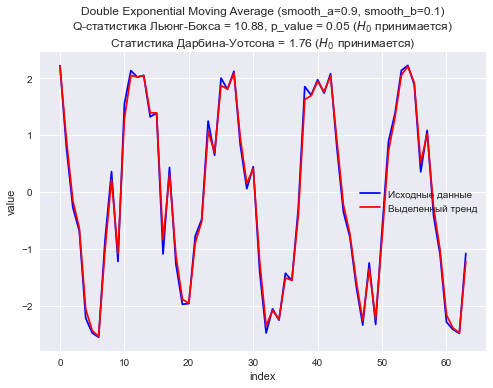

In [14]:
double_exponential_moving_average(sin_trend_data)

Выделение тренда для данных с линейным трендом (вся рассчитанная информация приведена на графике):

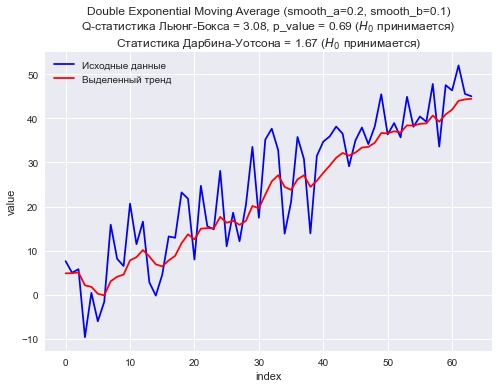

In [15]:
double_exponential_moving_average(lin_trend_data)